# Multi-scenario Multi-objective robust decision making (Multi-scenario MORDM)

In this script, the multi-scenario MORDM analysis is used to find a set of robust solutions for the flood risk management of the IJssel river.

The analysis was perfromed as followed:

1. MORDM
- Choosing Reference Scenario
- Searching for optimal NFE & epsilon pair to find convergence
- First subspace partitioning for deaths to decrease number of policy solutions
- Optimization for finding policies
- Reevaluating policies under uncertainty
2. Multi MORDM
- selecting scenarios for multi-scenario MORDM
- Optimising over 5 scenarios
- Second subspace partitioning for deaths and expected damage to decrease number of policy solutions
- Re-evaluating under deep uncertainty
- Robustness metrics (Minimum regret & signal to noise)
- Sensitivity analysis SOBOL

### Import of libraries and packages

In [1]:
import pandas as pd
import numpy as np

#import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns


#ema workbench imports
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.analysis import parcoords
from ema_workbench import Policy
from ema_workbench import save_results
from ema_workbench import load_results
from ema_workbench import Scenario
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem, epsilon_nondominated)
from ema_workbench import ScalarOutcome
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench import Samplers
from ema_workbench.em_framework import get_SALib_problem
from SALib.analyze.sobol import analyze

#import of functions
from problem_formulation import get_model_for_problem_formulation




# MORDM
For the reference scenario, average values are used for the uncertainties as no agreement was reached between the actors.

The analysis is based on problem formulation 2. We chose 10,000 function evaluations, as even with 100,000 nfes there was no convergence and with 10,000 nfes the computing time was still reasonable. Additionally, we use an epsilon of 0.25, limiting the amount of policies generated.


### Reference scenario

In [4]:
#importing model function and choosing problem formulation 2
model, planning_steps = get_model_for_problem_formulation(2)

#setting average values for reference scenario
reference_scenario = Scenario('reference', **{'discount rate 0': 2.5, 'discount rate 1': 2.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 66, 
                                              'A.1_Bmax': 160, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5, 
                                              'A.2_Bmax': 160, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5, 
                                              'A.3_Bmax': 160, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 160, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5, 
                                              'A.5_Bmax': 160, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

### Search for Candidate Solutions: Single-Scenario Multi-Objective Optimisation

In [15]:
convergence_metrics = [EpsilonProgress()]
nfe = 10000 # number of functional evaluations
epsilon = [0.25,] * len(model.outcomes) #epsilon value (sensitive to gaps in the pareto front)

ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=reference_scenario)

[MainProcess/INFO] pool started with 8 workers
10703it [1:06:15,  2.69it/s]                                                   
[MainProcess/INFO] optimization completed, found 187 solutions
[MainProcess/INFO] terminating pool


In [16]:
archive, convergence = total
print("Number of policies: ",len(archive))

187


In [ ]:
#saving single MORDM results
#save_results(total, 'MORDM_10000_0.25_pf2.tar.gz'.format(nfe)) #result from optimise is different to result from evaluate --> error
convergence.to_csv('data/MORDM_10000_0.25_pf2_convergence.csv')
archive.to_csv('data/MORDM_10000_0.25_pf2_archive.csv')

### Convergence Check

In [2]:
archive = pd.read_csv('data/MORDM_10000_0.25_pf2_archive.csv', header=[0], index_col=[0])
convergence = pd.read_csv('data/MORDM_10000_0.25_pf2_convergence.csv', header=[0], index_col=[0])

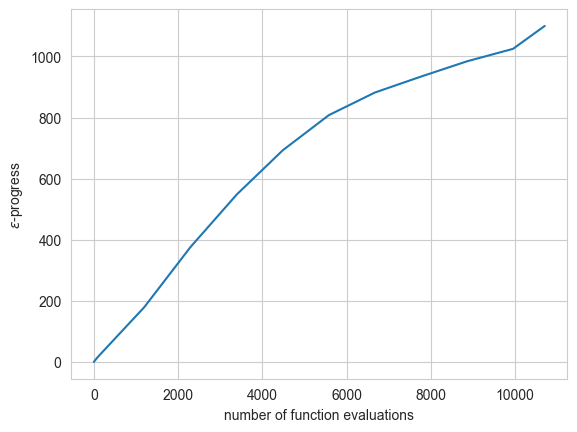

In [17]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.savefig('plots/convergence_S-MORDM')
plt.show()

### Plotting policies from single MORDM in parcood plot

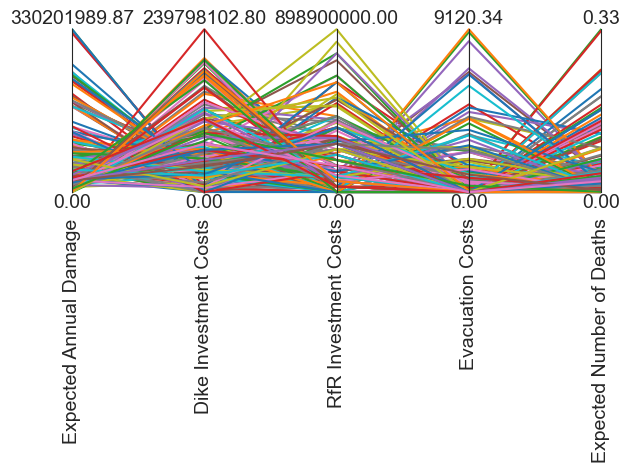

In [24]:
data = archive.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.savefig('plots/parcoord_policies_S-MORDM')
plt.show()

### Subspace Partitioning

Setting threshold for expected number of deaths to respect safety concerns of Rijkswaterstaat and reduce computational costs. All policies that result in an Expected Number of Deaths below the median in the average reference scenario are selected, i.e. the half of policies that perform better on minimising casualties in the reference scenario.

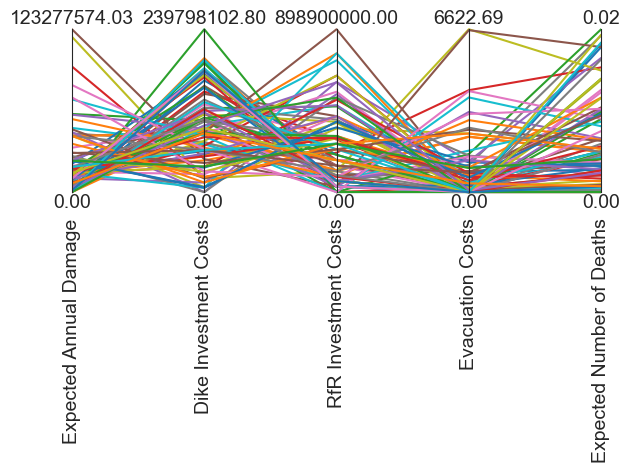

In [25]:
archive_subspace = archive.loc[archive['Expected Number of Deaths'] < archive['Expected Number of Deaths'].median()]

data = archive_subspace.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.savefig('plots/parcoord_policies_S-MORDM_subDeaths')
plt.show()

In [14]:
print("Number of policies: ",len(archive_subspace))

Number of policies:  93


In [14]:
policies = archive_subspace
policies = policies.drop([o.name for o in model.outcomes], axis=1)

policies_to_evaluate = []
for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

Now the constraint is set, the policies can be re-evaluated over the 1000 scenarios.

## Re-evaluate candidate solutions under uncertainty
The optimization over the average reference scenario resulted in 93 candidate solutions. These need to be re-evaluated under uncertainty. Therefore, 1000 scenarios are explored per policy. Exploring over more scenarios results in very high computing time.




In [15]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

100%|██████████████████████████████████| 93000/93000 [7:31:00<00:00,  3.44it/s]


In [1]:
save_results(results, 'MORDM_1000_scen_nfe10000_0.25.tar.gz'.format(nfe))

NameError: name 'results' is not defined

In [23]:
experiments, outcomes = results
outcomes_df = pd.DataFrame.from_dict(outcomes)
outcomes_df['policy'] = experiments['policy']
experiments.to_csv('data/MORDM_10000_0.25_pf2_scen1000_experiments.csv')
outcomes_df.to_csv('data/MORDM_10000_0.25_pf2_scen1000_outcomes.csv')

## Scenario Discovery (selection of 5 scenarios for multi-scenario MORDM)

### worst case scenarios

In [3]:
results = load_results('MORDM_1000_scen_nfe10000_0.25.tar.gz')
experiments, outcomes = results

### Plot of worst case scenarios

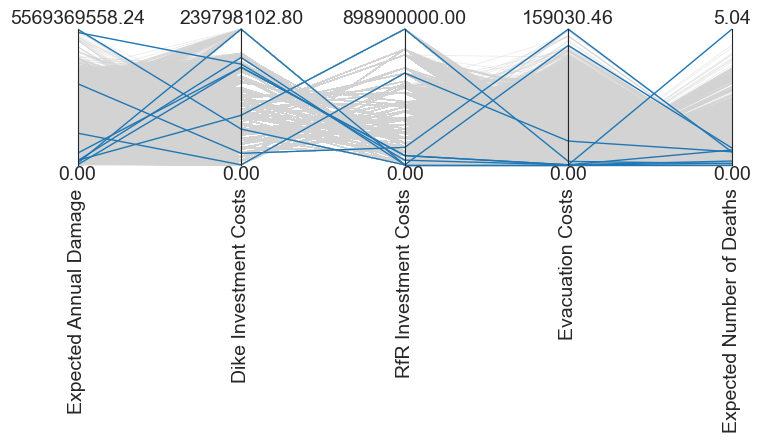

In [5]:
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()
limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha to analyze results
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)

fig = plt.gcf()
fig.set_size_inches((8, 4))
plt.savefig('plots/parcoord_worst_best_sc_S-MORDM_subDeaths')
plt.show()

In [6]:
#Identify worst and best case scenarios
print(all_data.idxmax())
print(all_data.idxmin())

Expected Annual Damage       66407
Dike Investment Costs        52000
RfR Investment Costs         45000
Evacuation Costs             28846
Expected Number of Deaths    86407
dtype: int64
Expected Annual Damage          81
Dike Investment Costs        24000
RfR Investment Costs          2000
Evacuation Costs                 0
Expected Number of Deaths       81
dtype: int64


In [4]:
# also all we need are the uncertainty columns
selected = experiments.loc[[66407, 52000, 45000, 28846, 86407], ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2']]
selected

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
66407,124,314.400203,1.0,0.203345,315.901903,1.5,0.151716,221.445269,1.5,0.006179,154.539650,10.0,0.568681,335.326317,1.0,0.055939,4.5,1.5,1.5
52000,99,76.575130,1.0,0.523442,310.952861,10.0,0.100802,334.787144,1.0,0.078870,172.968460,1.0,0.643187,236.484828,10.0,0.339104,1.5,2.5,1.5
45000,99,76.575130,1.0,0.523442,310.952861,10.0,0.100802,334.787144,1.0,0.078870,172.968460,1.0,0.643187,236.484828,10.0,0.339104,1.5,2.5,1.5
28846,24,169.528991,1.0,0.419505,249.610738,10.0,0.038312,289.853217,1.5,0.019409,144.907506,1.0,0.880484,247.959228,10.0,0.694520,2.5,1.5,2.5
86407,124,314.400203,1.0,0.203345,315.901903,1.5,0.151716,221.445269,1.5,0.006179,154.539650,10.0,0.568681,335.326317,1.0,0.055939,4.5,1.5,1.5


In [5]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]
scenarios

[Scenario({'A.0_ID flood wave shape': 124.0, 'A.1_Bmax': 314.4002028447528, 'A.1_Brate': 1.0, 'A.1_pfail': 0.2033447499894587, 'A.2_Bmax': 315.9019028751663, 'A.2_Brate': 1.5, 'A.2_pfail': 0.1517155795651275, 'A.3_Bmax': 221.4452687589414, 'A.3_Brate': 1.5, 'A.3_pfail': 0.0061792096004361, 'A.4_Bmax': 154.539650353164, 'A.4_Brate': 10.0, 'A.4_pfail': 0.568681083469557, 'A.5_Bmax': 335.3263166681378, 'A.5_Brate': 1.0, 'A.5_pfail': 0.0559391889218384, 'discount rate 0': 4.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5}),
 Scenario({'A.0_ID flood wave shape': 99.0, 'A.1_Bmax': 76.5751304155243, 'A.1_Brate': 1.0, 'A.1_pfail': 0.5234420322496701, 'A.2_Bmax': 310.95286100149747, 'A.2_Brate': 10.0, 'A.2_pfail': 0.1008020491568245, 'A.3_Bmax': 334.7871437375114, 'A.3_Brate': 1.0, 'A.3_pfail': 0.0788696871333113, 'A.4_Bmax': 172.96845993734274, 'A.4_Brate': 1.0, 'A.4_pfail': 0.6431869600263594, 'A.5_Bmax': 236.48482755032444, 'A.5_Brate': 10.0, 'A.5_pfail': 0.3391042179118312, 'discount rate

In [9]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

## Multi-Scenario Multi-Objective MORDM

In [13]:
ema_logging.log_to_stderr(ema_logging.INFO)

def optimize(scenario, nfe, model, epsilons):
    results = []
    convergences = []

    with MultiprocessingEvaluator(model) as evaluator:
        #for i in range(5): # random seeds cannot be done due to computing power limitations
        convergence_metrics = [
            ArchiveLogger(
                "./data3",
                [l.name for l in model.levers],
                [o.name for o in model.outcomes],
                base_filename=f"MORDM_0.25_{scenario.name}.tar.gz",
            ),
            EpsilonProgress(),]

        result, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                        convergence=convergence_metrics,
                                        epsilons=epsilons,
                                        reference=scenario)

        results.append(result)
        convergences.append(convergence)

    # As no random seeds were used because of computing power, this step is not required and the results are returned directly
    return result, convergence

results = []
for scenario in scenarios:
    epsilons = [0.25,] * len(model.outcomes)
    results.append(optimize(scenario, 10000, model, epsilons))


[MainProcess/INFO] pool started with 8 workers
11269it [52:24,  3.58it/s]                                                     
[MainProcess/INFO] optimization completed, found 309 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
10907it [49:35,  3.67it/s]                                                     
[MainProcess/INFO] optimization completed, found 254 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
10824it [48:56,  3.69it/s]                                                     
[MainProcess/INFO] optimization completed, found 206 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
11137it [54:59,  3.38it/s]                                                     
[MainProcess/INFO] optimization completed, found 311 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
11289it [1:14:46,  2.52it/s]                     

In [14]:
for i in range(len(scenarios)):
    archive, convergence = results[i]
    convergence.to_csv('data/MORDM_10_0-25_pf2_convergence_scenario'+str(i)+'.csv')
    archive.to_csv('data/MORDM_10_0-25_pf2_archive_scenario'+str(i)+'.csv')

In [12]:
from ema_workbench import Policy

policies = []
for i in range(len(scenarios)):
    result = pd.read_csv('data/MORDM_10_0-25_pf2_archive_scenario'+str(i)+'.csv', header=[0], index_col=[0])
    result_subspace = result.loc[result['Expected Number of Deaths'] < result['Expected Number of Deaths'].median()]
    result_subspace = result_subspace.loc[result_subspace['Expected Annual Damage'] < result_subspace['Expected Annual Damage'].median()]
    policy_subspace = result_subspace.iloc[:, 0:-5]
    for j, row in policy_subspace.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)


In [13]:
print("Number of policies for Multi MORDM: ",len(policies))

363

/Users/Mira/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


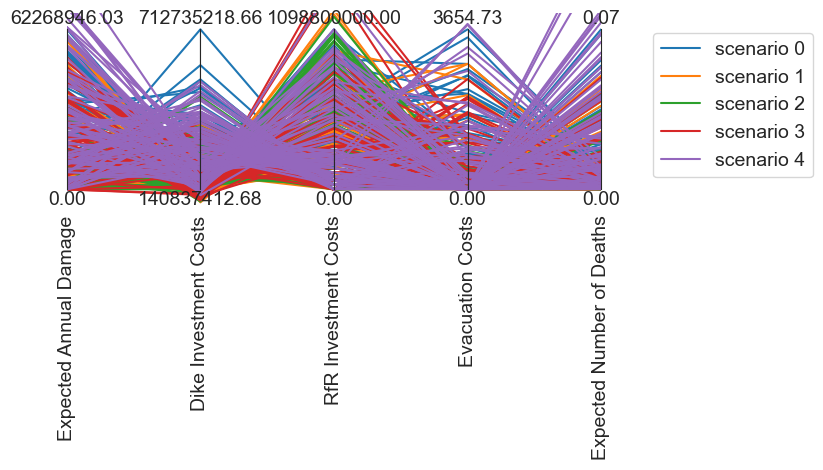

In [7]:
colors = iter(sns.color_palette())

result = pd.read_csv('data/MORDM_10_0-25_pf2_archive_scenario'+str(0)+'.csv', header=[0], index_col=[0])
result_subspace = result.loc[result['Expected Number of Deaths'] < result['Expected Number of Deaths'].median()]
result_subspace = result_subspace.loc[result_subspace['Expected Annual Damage'] < result_subspace['Expected Annual Damage'].median()]
#result_subspace = result_subspace.loc[result_subspace['Dike Investment Costs'] < result_subspace['Dike Investment Costs'].median()]
#result_subspace = result_subspace.loc[result_subspace['RfR Investment Costs'] < result_subspace['RfR Investment Costs'].median()]
data = result_subspace.iloc[:, -5::]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)

for i in range(len(scenarios)):
    color = next(colors)
    result = pd.read_csv('data/MORDM_10_0-25_pf2_archive_scenario'+str(i)+'.csv', header=[0], index_col=[0])
    result_subspace = result.loc[result['Expected Number of Deaths'] < result['Expected Number of Deaths'].median()]
    result_subspace = result_subspace.loc[result_subspace['Expected Annual Damage'] < result_subspace['Expected Annual Damage'].median()]
    #result_subspace = result_subspace.loc[result_subspace['Dike Investment Costs'] < result_subspace['Dike Investment Costs'].median()]
    #result_subspace = result_subspace.loc[result_subspace['RfR Investment Costs'] < result_subspace['RfR Investment Costs'].median()]
    data = result_subspace.iloc[:, -5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.savefig('plots/parcoord_policies_MS-MORDM_subDeathsDamage')
plt.show()


## Re-evaluate under deep uncertainty

We re-evaluated the policies under deep uncertainity over 100 scenarios due to limited computing power.


In [11]:
with MultiprocessingEvaluator(model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(100, policies=policies)

100%|██████████████████████████████████| 36300/36300 [2:56:37<00:00,  3.43it/s]


In [12]:
reeevaluation_results

(       A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax   
 0                           35  299.772373      10.0   0.567435  202.835429  \
 1                           91  274.247799      10.0   0.626519  201.461199   
 2                           97  161.105320       1.0   0.994003  121.412192   
 3                          103  253.426307       1.5   0.292693  152.941713   
 4                          112  127.625312       1.0   0.081216  141.642757   
 ...                        ...         ...       ...        ...         ...   
 36295                       74   79.114131      10.0   0.156317  303.753699   
 36296                      131  112.413924       1.5   0.407428   71.066465   
 36297                       37  152.676348       1.0   0.183623  326.072696   
 36298                       71  167.739643      10.0   0.890675  185.122144   
 36299                      121  213.553385       1.5   0.026611  240.654075   
 
       A.2_Brate  A.2_pfail    A.3_Bma

In [13]:
experiments, outcomes = reeevaluation_results

In [14]:
save_results(reeevaluation_results, 'MSMORDM_reeva_100_scen_nfe10000_0.25.tar.gz'.format(nfe))

In [15]:
outcomes_df = pd.DataFrame.from_dict(outcomes)
outcomes_df['policy'] = experiments['policy']
experiments.to_csv('data/MSMORDM_reeva_100_scen_nfe10000_0.25_experiments.csv')
outcomes_df.to_csv('data/MSMORDM_reeva_100_scen_nfe10000_0.25_outcomes.csv')


In [5]:
reeevaluation_results = load_results('MSMORDM_reeva_100_scen_nfe10000_0.25.tar.gz')
experiments, outcomes = reeevaluation_results

### Robustness metrics

Having a set of optimal policies, we now want to test the robustness of the individual policies to find the policy that performs well under most scenarios with little variance over the different uncertainties. First we performed the minimum regret metric to find 10 policies which have the smallest regret value. Over the 10 selected policies we performed a signal to noise analysis to find the policy with minimal mean and standard deviation.


**Minimum regret**

Regret is the difference between the performance of a policy in a specific scenario and the best possible performance of a policy in that scenario. The minimum regret is the minimum regret value of a policy across all scenarios.
The lowest minimum regret values are desired since all outcomes are minimized. To avoid negative values, the absolute difference is calculated.

In [6]:
experiments, outcomes = reeevaluation_results
overall_regret = {}
min_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    data_min = pd.DataFrame()

    for i in range(0,data.shape[1],1):
        data_min = pd.concat([data_min, data.min(axis=1)], axis=1)

    data_min = data_min.set_axis(data.columns, axis=1)

    outcome_regret = (data_min - data).abs()

    overall_regret[outcome.name] = outcome_regret
    min_regret[outcome.name] = outcome_regret.min()
min_regret = pd.DataFrame(min_regret)

In [7]:
min_regret_norm = min_regret/min_regret.max()
min_regret_norm

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
scenario 0 option 1,0.000000,1.000000,0.020008,0.0,0.000
scenario 0 option 103,0.000000,0.660073,0.000000,0.0,0.000
scenario 0 option 11,0.023812,0.507966,0.000000,0.0,0.027
scenario 0 option 12,0.000000,0.216106,0.529197,0.0,0.000
scenario 0 option 120,0.000000,0.257483,0.518118,0.0,0.000
...,...,...,...,...,...
scenario 4 option 89,0.000000,0.221414,0.139012,0.0,0.000
scenario 4 option 90,0.000000,0.510811,0.040016,0.0,0.000
scenario 4 option 93,0.000000,0.065345,0.581986,0.0,0.000


In [8]:
min_regret_norm.sum(1).sort_values().iloc[:10].index.to_list()

['scenario 1 option 122',
 'scenario 2 option 153',
 'scenario 1 option 6',
 'scenario 1 option 3',
 'scenario 2 option 114',
 'scenario 1 option 182',
 'scenario 2 option 186',
 'scenario 1 option 118',
 'scenario 2 option 54',
 'scenario 3 option 29']

In [9]:
min_regret_norm.loc[min_regret_norm.sum(1).sort_values().iloc[:10].index.to_list()]

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
scenario 1 option 122,0.0,0.162967,0.000000,0.0,0.0
scenario 2 option 153,0.0,0.145470,0.020008,0.0,0.0
scenario 1 option 6,0.0,0.070523,0.095151,0.0,0.0
scenario 1 option 3,0.0,0.074082,0.095151,0.0,0.0
scenario 2 option 114,0.0,0.115546,0.055136,0.0,0.0
scenario 1 option 182,0.0,0.158401,0.020008,0.0,0.0
scenario 2 option 186,0.0,0.158887,0.020008,0.0,0.0
scenario 1 option 118,0.0,0.162967,0.020008,0.0,0.0
scenario 2 option 54,0.0,0.189832,0.000000,0.0,0.0


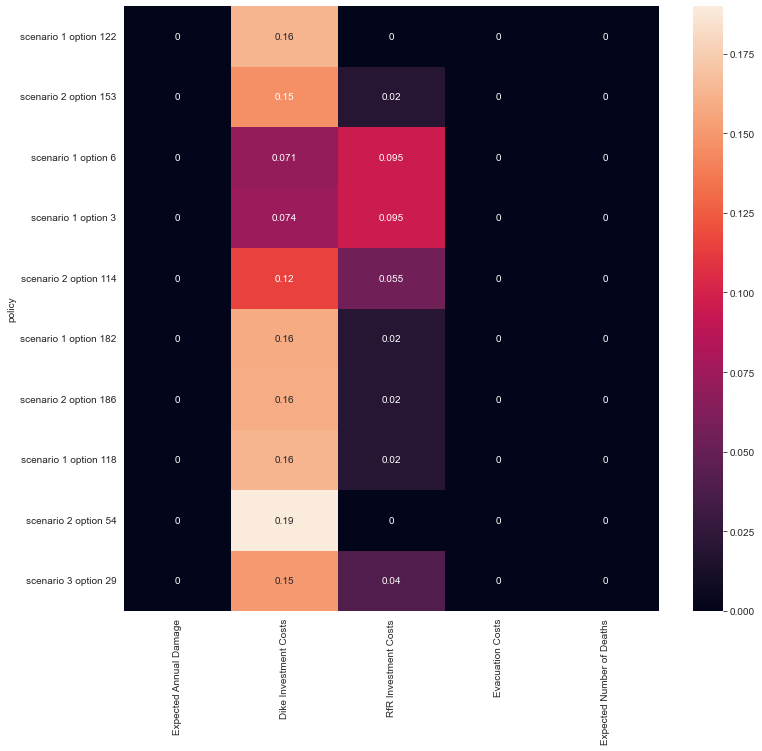

In [10]:
min_regret = pd.DataFrame(min_regret)
plt.figure(figsize = (12,14))
sns.heatmap(min_regret_norm.loc[min_regret_norm.sum(1).sort_values().iloc[:10].index.to_list()], annot=True)
plt.subplots_adjust(bottom = 0.28)
#sns.set(rc={'figure.figuresize':(15,8)})
#fig.tight_layout()
#fig.set_size_inches(12,12)
plt.savefig('plots/heatmap_regret')
plt.show()


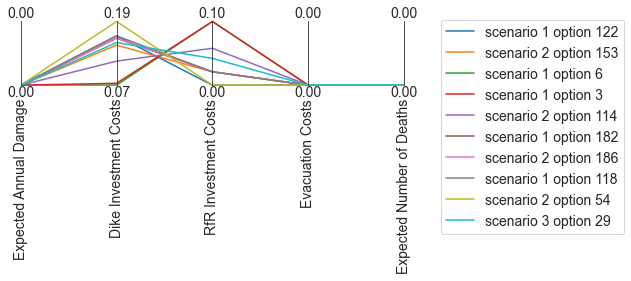

In [11]:
data = min_regret_norm.loc[min_regret_norm.sum(1).sort_values().iloc[:10].index.to_list()]

colors = sns.color_palette(n_colors=len(data))

limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.savefig('regret parcoords')
plt.show()

**Signal-to-noise ratio**

In [12]:
for policy in np.unique(experiments['policy']):
    logical = experiments['policy']==policy
    for outcome in model.outcomes:
        print(outcome.name, np.std(outcomes[outcome.name][logical]))

Expected Annual Damage 168578816.61967036
Dike Investment Costs 3.5762786865234375e-07
RfR Investment Costs 0.0
Evacuation Costs 1196.1373439246634
Expected Number of Deaths 0.04707732914775086
Expected Annual Damage 261723746.41798535
Dike Investment Costs 1.7881393432617188e-07
RfR Investment Costs 0.0
Evacuation Costs 3852.0531150683337
Expected Number of Deaths 0.025475708776618942
Expected Annual Damage 119695875.01919672
Dike Investment Costs 1.1920928955078125e-07
RfR Investment Costs 0.0
Evacuation Costs 0.0
Expected Number of Deaths 0.09970512506234185
Expected Annual Damage 177174207.87681043
Dike Investment Costs 2.9802322387695312e-08
RfR Investment Costs 0.0
Evacuation Costs 0.0
Expected Number of Deaths 0.1485533787219043
Expected Annual Damage 283076722.6183793
Dike Investment Costs 8.940696716308594e-08
RfR Investment Costs 0.0
Evacuation Costs 0.0
Expected Number of Deaths 0.22034428338069187
Expected Annual Damage 224186183.06768218
Dike Investment Costs 1.19209289550

In [13]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
s_to_n_ = pd.DataFrame.from_dict(overall_scores).T
s_to_n_.drop('Dike Investment Costs', axis=1, inplace=True)
s_to_n_.drop('RfR Investment Costs', axis=1, inplace=True)
s_to_n_

,Expected Annual Damage,Evacuation Costs,Expected Number of Deaths
scenario 0 option 1,8.523349e+15,5.961762e+05,0.000652
scenario 0 option 103,1.902463e+16,5.308087e+06,0.000177
scenario 0 option 11,6.424638e+15,0.000000e+00,0.004112
scenario 0 option 12,6.529872e+15,0.000000e+00,0.004360
scenario 0 option 120,1.374187e+16,0.000000e+00,0.008318
...,...,...,...
scenario 4 option 89,1.025610e+17,4.025946e+07,0.000806
scenario 4 option 90,3.723327e+16,4.706952e+06,0.000503
scenario 4 option 93,9.167390e+16,1.764572e+07,0.001011
scenario 4 option 94,1.031300e+17,0.000000e+00,0.050608


In [14]:
s_to_n_

,Expected Annual Damage,Evacuation Costs,Expected Number of Deaths
scenario 0 option 1,8.523349e+15,5.961762e+05,0.000652
scenario 0 option 103,1.902463e+16,5.308087e+06,0.000177
scenario 0 option 11,6.424638e+15,0.000000e+00,0.004112
scenario 0 option 12,6.529872e+15,0.000000e+00,0.004360
scenario 0 option 120,1.374187e+16,0.000000e+00,0.008318
...,...,...,...
scenario 4 option 89,1.025610e+17,4.025946e+07,0.000806
scenario 4 option 90,3.723327e+16,4.706952e+06,0.000503
scenario 4 option 93,9.167390e+16,1.764572e+07,0.001011
scenario 4 option 94,1.031300e+17,0.000000e+00,0.050608


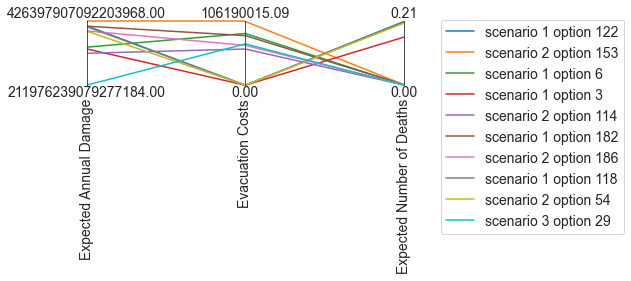

In [15]:
min_regret_norm = min_regret/min_regret.max()
data = s_to_n_.loc[min_regret_norm.sum(1).sort_values().iloc[:10].index.to_list()]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
#paraxes.plot(data)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=sns.color_palette()[i])
paraxes.legend()

plt.savefig('s_to_n parcoords')
plt.show()

In [16]:
print(experiments[experiments['policy'] == 'scenario 2 option 114'].iloc[0,-34:])

0_RfR 0                                   0
0_RfR 1                                   1
0_RfR 2                                   0
1_RfR 0                                   0
1_RfR 1                                   0
1_RfR 2                                   0
2_RfR 0                                   0
2_RfR 1                                   0
2_RfR 2                                   0
3_RfR 0                                   0
3_RfR 1                                   0
3_RfR 2                                   0
4_RfR 0                                   0
4_RfR 1                                   0
4_RfR 2                                   0
EWS_DaysToThreat                          3
A.1_DikeIncrease 0                        0
A.1_DikeIncrease 1                        0
A.1_DikeIncrease 2                        0
A.2_DikeIncrease 0                        7
A.2_DikeIncrease 1                        0
A.2_DikeIncrease 2                        0
A.3_DikeIncrease 0              

In [17]:
experiments[experiments['policy'] == 'scenario 1 option 3'].iloc[0,-34:]

0_RfR 0                                 1
0_RfR 1                                 0
0_RfR 2                                 0
1_RfR 0                                 0
1_RfR 1                                 0
1_RfR 2                                 0
2_RfR 0                                 0
2_RfR 1                                 1
2_RfR 2                                 1
3_RfR 0                                 0
3_RfR 1                                 0
3_RfR 2                                 0
4_RfR 0                                 0
4_RfR 1                                 0
4_RfR 2                                 0
EWS_DaysToThreat                        0
A.1_DikeIncrease 0                      0
A.1_DikeIncrease 1                      0
A.1_DikeIncrease 2                      0
A.2_DikeIncrease 0                      3
A.2_DikeIncrease 1                      0
A.2_DikeIncrease 2                      0
A.3_DikeIncrease 0                      6
A.3_DikeIncrease 1                

### SOBOL analysis

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    experiments, results = evaluator.perform_experiments(100, policies, #top policy has to be chosen here
                                                         uncertainty_sampling=Samplers.SOBOL)

In [ ]:
problem = get_SALib_problem(model.uncertainties)
problem

### Sensitivity index


We will create a sensitivity index plot, displaying the S1 (First-order), S2 (Second-order), and ST (Total-order) sensitivity indexes, to compare the influence of input parameters on the reliability objective across three release policies. This will provide insights into the importance of different uncertainties under each policy.

In [ ]:
sobol_results = {}
for policy in experiments.policy.unique(): #only for one policy
    logical = experiments.policy == policy
    y = results['reliability'][logical]
    indices = analyze(problem, y)
    sobol_results[policy] = indices

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(8, 4)
plt.savefig('SOBOL_plot')
indices.plot(ax=axes)